In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

np.random.seed(42)
tf.random.set_seed(42)


In [3]:
# dataset_path = "American2"  

# # Image parameters for MobileNetV2
# img_height, img_width = 96, 96 
# batch_size = 32
# num_classes = 28 # A-Z Space NoSign

# # --- DATA PREPARATION ---
# # Create a data generator with augmentation for the training set
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=False,
#     fill_mode='nearest',
#     validation_split=0.2  # Use 20% of the data for validation
# )

# # Create the training data generator
# train_generator = train_datagen.flow_from_directory(
#     dataset_path,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training',
#     shuffle=True
# )

# # Create the validation data generator
# # NOTE: shuffle=False is important for later evaluation (confusion matrix)
# validation_generator = train_datagen.flow_from_directory(
#     dataset_path,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation',
#     shuffle=False
# )

# # Get the mapping of class names to indices
# class_indices = train_generator.class_indices
# print("Class Indices (Mapping):", class_indices)

In [3]:
dataset_path = "American2"  

img_height, img_width = 96, 96 
batch_size = 32
num_classes = 28  # A–Z, Space, NoSign


train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25  # 25% for val
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_indices = train_generator.class_indices
print("Class Indices (Mapping):", class_indices)


Found 81472 images belonging to 28 classes.
Found 27139 images belonging to 28 classes.
Class Indices (Mapping): {'No Sign': 0, 'Space': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}


### DataSet View: -

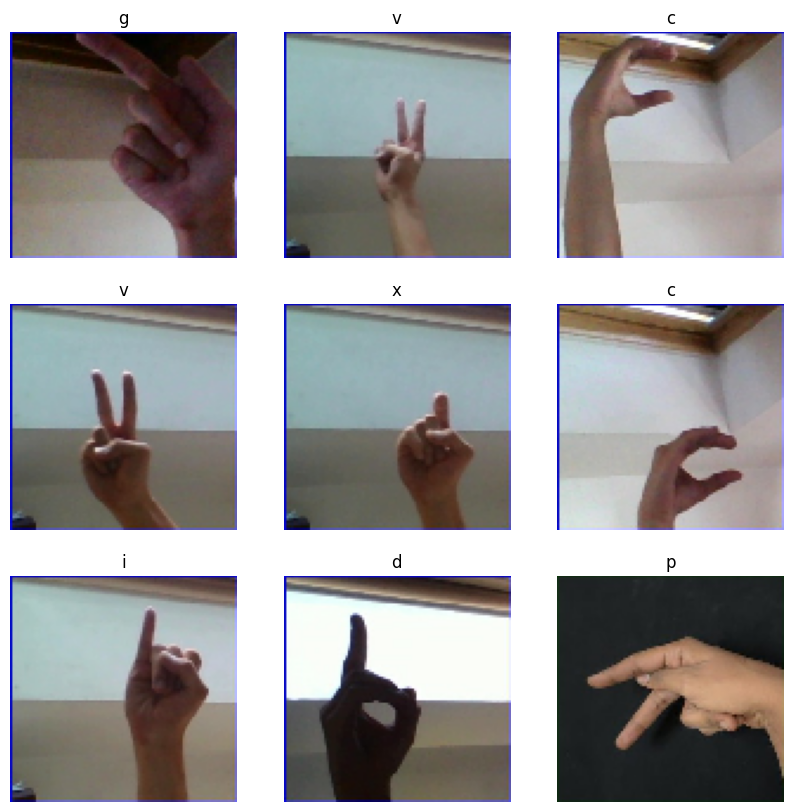

In [4]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    label_index = np.argmax(y_batch[i])
    class_labels = list(class_indices.keys())
    plt.title(class_labels[label_index])
    plt.axis("off")
plt.show()

## **Model Trainning: -**

### **Use a pre trained(MobileNetV2) model on our dataset**

In [6]:
# # pre-trained MobileNetV2 model 
# base_model = MobileNetV2(
#     input_shape=(img_height, img_width, 3),
#     include_top=False,  
#     weights='imagenet'  # Use weights 
# )

# base_model.trainable = False

# x = base_model.output
# x = GlobalAveragePooling2D()(x)  
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)  
# predictions = Dense(num_classes, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # model.summary()

In [6]:
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)

# layer 1
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# layer 2
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# layer 3 
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)


predictions = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
checkpoint = ModelCheckpoint(
    'sign_language_model_best4.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20


/Users/yuvrajbhatkariya/data/VScode.C++/Projects/Sign_to_speech/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5866 - loss: 2.7990
Epoch 1: val_accuracy improved from None to 0.91543, saving model to sign_language_model_best4.h5


2546/2546 ━━━━━━━━━━━━━━━━━━━━ 211s 82ms/step - accuracy: 0.7875 - loss: 1.9825 - val_accuracy: 0.9154 - val_loss: 1.3582
Epoch 2/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9570 - loss: 1.1863
Epoch 2: val_accuracy improved from 0.91543 to 0.93820, saving model to sign_language_model_best4.h5


2546/2546 ━━━━━━━━━━━━━━━━━━━━ 205s 81ms/step - accuracy: 0.9658 - loss: 1.0916 - val_accuracy: 0.9382 - val_loss: 1.0418
Epoch 3/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9820 - loss: 0.8471
Epoch 3: val_accuracy did not improve from 0.93820
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 206s 81ms/step - accuracy: 0.9833 - loss: 0.7848 - val_accuracy: 0.9312 - val_loss: 0.8549
Epoch 4/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9878 - loss: 0.6138
Epoch 4: val_accuracy improved from 0.93820 to 0.93879, saving model to sign_language_model_best4.h5


2546/2546 ━━━━━━━━━━━━━━━━━━━━ 216s 85ms/step - accuracy: 0.9885 - loss: 0.5688 - val_accuracy: 0.9388 - val_loss: 0.6863
Epoch 5/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9894 - loss: 0.4574
Epoch 5: val_accuracy did not improve from 0.93879
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 211s 83ms/step - accuracy: 0.9898 - loss: 0.4284 - val_accuracy: 0.9320 - val_loss: 0.5863
Epoch 6/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9917 - loss: 0.3503
Epoch 6: val_accuracy improved from 0.93879 to 0.94745, saving model to sign_language_model_best4.h5


2546/2546 ━━━━━━━━━━━━━━━━━━━━ 207s 81ms/step - accuracy: 0.9911 - loss: 0.3341 - val_accuracy: 0.9474 - val_loss: 0.4708
Epoch 7/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9913 - loss: 0.2832
Epoch 7: val_accuracy did not improve from 0.94745
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 211s 83ms/step - accuracy: 0.9917 - loss: 0.2687 - val_accuracy: 0.9394 - val_loss: 0.4507
Epoch 8/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9924 - loss: 0.2306
Epoch 8: val_accuracy improved from 0.94745 to 0.95058, saving model to sign_language_model_best4.h5


2546/2546 ━━━━━━━━━━━━━━━━━━━━ 263s 103ms/step - accuracy: 0.9922 - loss: 0.2214 - val_accuracy: 0.9506 - val_loss: 0.3547
Epoch 9/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9936 - loss: 0.1912
Epoch 9: val_accuracy did not improve from 0.95058
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 203s 80ms/step - accuracy: 0.9935 - loss: 0.1840 - val_accuracy: 0.9496 - val_loss: 0.3345
Epoch 10/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9922 - loss: 0.1677
Epoch 10: val_accuracy did not improve from 0.95058
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 215s 85ms/step - accuracy: 0.9925 - loss: 0.1623 - val_accuracy: 0.9500 - val_loss: 0.3131
Epoch 11/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9930 - loss: 0.1477
Epoch 11: val_accuracy improved from 0.95058 to 0.95220, saving model to sign_language_model_best4.h5


2546/2546 ━━━━━━━━━━━━━━━━━━━━ 223s 87ms/step - accuracy: 0.9934 - loss: 0.1432 - val_accuracy: 0.9522 - val_loss: 0.3272
Epoch 12/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9947 - loss: 0.1270
Epoch 12: val_accuracy did not improve from 0.95220
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 232s 91ms/step - accuracy: 0.9939 - loss: 0.1257 - val_accuracy: 0.9472 - val_loss: 0.3242
Epoch 13/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9932 - loss: 0.1192
Epoch 13: val_accuracy did not improve from 0.95220
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 234s 92ms/step - accuracy: 0.9933 - loss: 0.1177 - val_accuracy: 0.9425 - val_loss: 0.3279
Epoch 14/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9943 - loss: 0.1078
Epoch 14: val_accuracy did not improve from 0.95220
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 251s 98ms/step - accuracy: 0.9939 - loss: 0.1070 - val_accuracy: 0.9420 - val_loss: 0.3181
Epoch 15/20
2546/2546 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9937 - loss: 0.1

In [11]:
with open("class_indices4.json", "w") as f:
    json.dump(class_indices, f)

print("✅ Class indices saved to class_indices.json")


✅ Class indices saved to class_indices.json


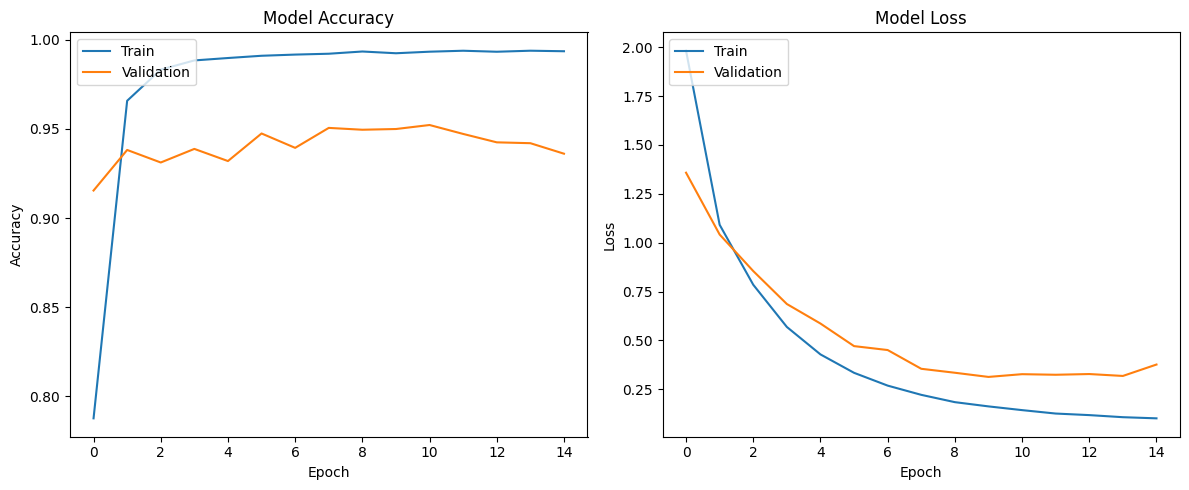

849/849 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - accuracy: 0.9522 - loss: 0.3271

Validation Loss: 0.3271
Validation Accuracy: 0.9522
849/849 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step

Classification Report:
              precision    recall  f1-score   support

     No Sign       1.00      1.00      1.00        91
       Space       1.00      1.00      1.00      1471
           a       0.95      1.00      0.97      1517
           b       0.94      1.00      0.97      1517
           c       0.98      1.00      0.99      1517
           d       0.94      0.99      0.97      1139
           e       0.99      0.90      0.94       700
           f       0.99      1.00      1.00       498
           g       0.83      0.99      0.90      1517
           h       0.99      1.00      1.00      1560
           i       0.93      1.00      0.96      1781
           j       1.00      1.00      1.00      1671
           k       0.98      1.00      0.99      1212
           l       1.00      1.00      1.00   

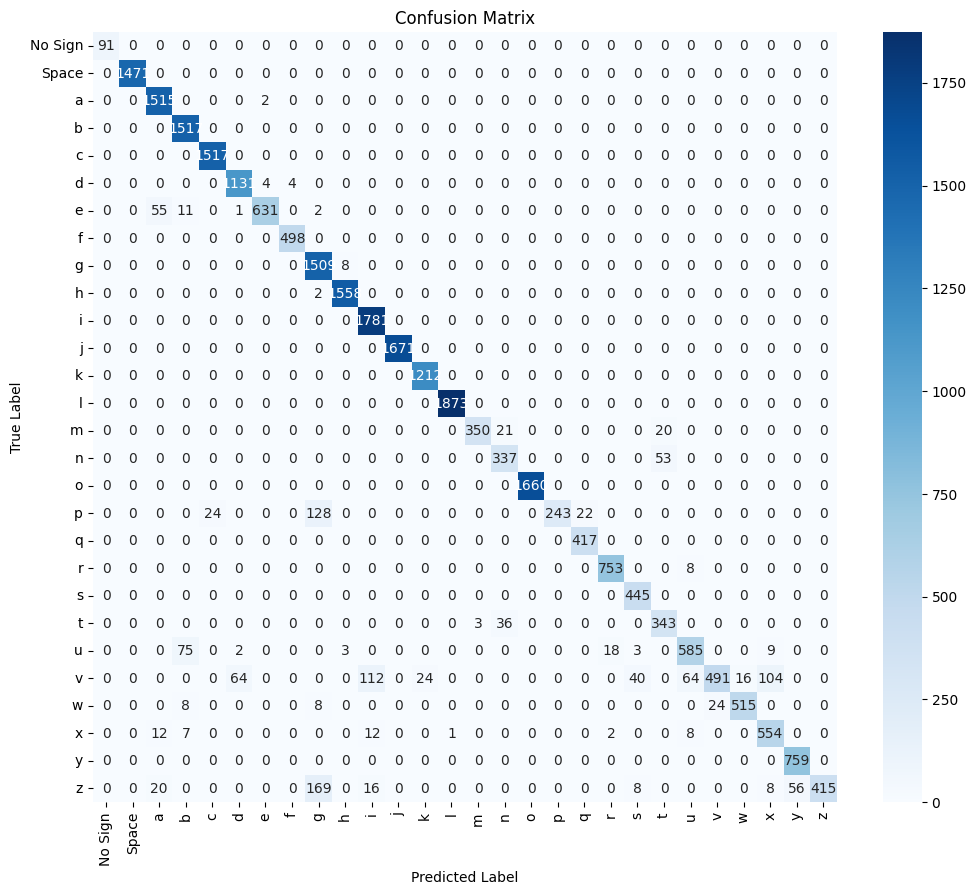

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

best_model = load_model('sign_language_model_best4.h5')

validation_loss, validation_accuracy = best_model.evaluate(validation_generator)
print(f"\nValidation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

y_pred_probs = best_model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator.classes

class_labels = list(class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
# model = load_model('sign_language_model_best4.h5')

# def predict_and_display(img_path, model, class_indices):
#     """
#     Loads an image, predicts the sign, and displays the result.
    
#     Args:
#         img_path (str): Path to the image file.
#         model: The trained Keras model.
#         class_indices (dict): Mapping from class name to index.
#     """
#     img = image.load_img(img_path, target_size=(img_height, img_width))
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)  
#     img_array /= 255.0  
    
#     predictions = model.predict(img_array)
#     predicted_class_index = np.argmax(predictions[0])
#     confidence = np.max(predictions[0])
    
#     index_to_class = {v: k for k, v in class_indices.items()}
#     predicted_class = index_to_class[predicted_class_index]
    
#     plt.figure(figsize=(6, 6))
#     plt.imshow(img)
#     plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}", fontsize=16)
#     plt.axis('off')
#     plt.show()
    
#     print(f"Model Prediction: {predicted_class}")
#     print(f"Confidence: {confidence:.2%}")

# test_image_path = "hand_captures/hand_10.jpg" # <--- CHANGE THIS PATH

# if os.path.exists(test_image_path):
#     predict_and_display(test_image_path, model, class_indices)
# else:
#     print(f"Error: The file '{test_image_path}' was not found.")
#     print("Please update the 'test_image_path' variable with a valid image path.")


In [ ]:
import cv2
import mediapipe as mp
import time
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import json

model = load_model("sign_language_model_best4.h5")

with open("class_indices4.json", "r") as f:
    class_indices = json.load(f)
index_to_class = {int(v): k for k, v in class_indices.items()}  

img_height, img_width = 96, 96

save_dir = "hand_predictions"
os.makedirs(save_dir, exist_ok=True)

capture_interval = 5 
padding = 70          
flash_duration = 0.3  
last_capture_time = time.time()
flash_start_time = None
flash_coords = None
img_count = 0

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

cap = cv2.VideoCapture(0)
predicted_letter = ""
confidence = 0.0

print("🖐 Starting real-time prediction... Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    h, w, _ = frame.shape
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    current_time = time.time()

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            x_min, y_min = w, h
            x_max, y_max = 0, 0
            for lm in hand_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x)
                y_max = max(y_max, y)

            x_min_pad = max(0, x_min - padding)
            y_min_pad = max(0, y_min - padding)
            x_max_pad = min(w, x_max + padding)
            y_max_pad = min(h, y_max + padding)

            cv2.rectangle(frame, (x_min_pad, y_min_pad),
                          (x_max_pad, y_max_pad), (0, 255, 0), 2)

            if current_time - last_capture_time >= capture_interval:
                last_capture_time = current_time
                img_count += 1

                hand_crop = frame[y_min_pad:y_max_pad, x_min_pad:x_max_pad]
                if hand_crop.size == 0:
                    continue

                img_resized = cv2.resize(hand_crop, (img_width, img_height))
                img_array = image.img_to_array(img_resized)
                img_array = np.expand_dims(img_array, axis=0) / 255.0

                predictions = model.predict(img_array)
                pred_index = np.argmax(predictions[0])
                confidence = np.max(predictions[0])
                predicted_letter = index_to_class.get(pred_index, "?")

                filename = os.path.join(
                    save_dir,
                    f"{predicted_letter}_{img_count}_{int(confidence*100)}.jpg"
                )
                cv2.imwrite(filename, hand_crop)

                flash_start_time = current_time
                flash_coords = (x_min_pad, y_min_pad, x_max_pad, y_max_pad)

                print(f"✅ {predicted_letter} ({confidence*100:.1f}%) saved as {filename}")

    if flash_start_time and current_time - flash_start_time < flash_duration and flash_coords:
        x1, y1, x2, y2 = flash_coords
        frame[y1:y2, x1:x2] = (0, 255, 0)

    if predicted_letter:
        cv2.putText(frame, f"Predicted: {predicted_letter} ({confidence*100:.1f}%)",
                    (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255, 255, 255), 3)

    time_remaining = int(capture_interval - (current_time - last_capture_time))
    if time_remaining > 0:
        cv2.putText(frame, f"Next capture in: {time_remaining}s",
                    (30, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    cv2.imshow("Sign Prediction (Live)", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("🛑 Exited safely.")


I0000 00:00:1764164121.217898 9644418 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1764164121.240279 9645969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764164121.246208 9645967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


🖐 Starting real-time prediction... Press 'q' to quit.


/Users/yuvrajbhatkariya/data/VScode.C++/Projects/Sign_to_speech/.venv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
✅ No Sign (97.1%) saved as hand_predictions/No Sign_1_97.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
✅ No Sign (70.4%) saved as hand_predictions/No Sign_2_70.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
✅ g (88.9%) saved as hand_predictions/g_3_88.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
✅ y (99.7%) saved as hand_predictions/y_4_99.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
✅ y (98.3%) saved as hand_predictions/y_5_98.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
✅ i (96.9%) saved as hand_predictions/i_6_96.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
✅ g (48.9%) saved as hand_predictions/g_7_48.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
✅ c (40.2%) saved as hand_predictions/c_8_40.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
✅ No Sign (53.2%) saved as hand_predictions/No Sign_9_53.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
✅ a (83.6%) saved as hand_predictions/a_10_83.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
✅ No Sign (99.4%) saved as hand_predictions/No Sign_11

KeyboardInterrupt: 

: 